# **Demostración de Técnicas de Preprocesamiento de Imágenes en Python**

## **Objetivo del Script:**
Este script muestra diversas técnicas comunes de preprocesamiento de imágenes utilizando bibliotecas populares de Python como OpenCV y Pillow. Cada técnica se ilustra cargando una imagen de ejemplo (desde un archivo local o el dataset CIFAR-10), aplicando la transformación y mostrando los resultados.

## **Estructura del Script:**
1.  Carga de las librerías necesarias.
2.  Configuración de la fuente de la imagen.
3.  Funciones auxiliares para visualización.
4.  Carga de una imagen de ejemplo (local o CIFAR-10).
5.  Aplicación y visualización de técnicas de preprocesamiento:
    * Conversión de Espacios de Color (Grises, RGB, HSV).
    * Redimensionamiento y Recorte.
    * Normalización de Píxeles y Ecualización de Histograma.
    * Aplicación de Filtros (Desenfoque Gaussiano, Mediana, Bilateral, Laplaciano).
    * Aumentación de Datos Básica (Volteo, Rotación, Ruido).

**Referencia Principal:** "Best Practices for Image Preprocessing | Keylabs" (https://keylabs.ai/blog/best-practices-for-image-preprocessing-in-image-classification/)

In [22]:
# ------------------------------------------------------------------------------
# 1. Carga de las Librerías
# ------------------------------------------------------------------------------
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter as PILImageFilter
import matplotlib.pyplot as plt
import os
import tensorflow as tf # Para cargar el dataset CIFAR-10

# Configuraciones opcionales para Matplotlib
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 10

print(f"OpenCV Version: {cv2.__version__}")
print(f"Pillow Version: {Image.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"TensorFlow Version: {tf.__version__}")

OpenCV Version: 4.11.0
Pillow Version: 11.1.0
NumPy Version: 2.1.3
TensorFlow Version: 2.19.0


In [23]:
# ------------------------------------------------------------------------------
# 2. Configuración de la Fuente de la Imagen
# ------------------------------------------------------------------------------
# Cambia USE_CIFAR10 a True para usar una imagen de CIFAR-10.
# Si es False, se intentará cargar la imagen especificada en IMAGE_PATH.
USE_CIFAR10 = False  # Prueba con True para CIFAR-10 o False para imagen local

# Índice de la imagen a usar del conjunto de entrenamiento de CIFAR-10 (0-49999).
# Solo se usa si USE_CIFAR10 es True.
CIFAR_IMAGE_INDEX = 40

# Ruta al archivo de imagen local. Solo se usa si USE_CIFAR10 es False.
# ASEGÚRATE DE QUE ESTE ARCHIVO EXISTA O MODIFICA LA RUTA.
IMAGE_PATH = os.path.join(os.getcwd(), 'Imagenes de Ejemplo', 'Imagen_1.jpg')
print(IMAGE_PATH)

/home/santiago/MADSI/Modelos_y_Metodos_de_Sistemas_Inteligentes/seccion_3/Imagenes de Ejemplo/Imagen_1.jpg


## **3. Funciones Auxiliares para Visualización**

Definiremos funciones para mostrar imágenes e histogramas.
La función `display_images` espera arrays NumPy en formato RGB para imágenes a color.

In [24]:
# --- Funciones Auxiliares ---

def display_images(original_img_rgb_or_gray, processed_img_rgb_or_gray,
                   title_original="Original", title_processed="Procesada",
                   cmap_original_gray=None, cmap_processed_gray='gray'):
    """
    Muestra la imagen original y la procesada una al lado de la otra.
    Espera arrays NumPy en formato RGB para imágenes a color, o escala de grises.
    """
    plt.figure(figsize=(12, 6))

    # Imagen Original
    plt.subplot(1, 2, 1)
    plt.title(title_original)
    if original_img_rgb_or_gray is None:
        plt.text(0.5, 0.5, "Imagen no disponible", ha='center', va='center')
    elif len(original_img_rgb_or_gray.shape) == 2: # Escala de grises
        plt.imshow(original_img_rgb_or_gray, cmap=cmap_original_gray if cmap_original_gray else 'gray')
    else: # Color (asumido RGB)
        plt.imshow(original_img_rgb_or_gray)
    plt.axis('off')

    # Imagen Procesada
    plt.subplot(1, 2, 2)
    plt.title(title_processed)
    if processed_img_rgb_or_gray is None:
        plt.text(0.5, 0.5, "Imagen no disponible", ha='center', va='center')
    elif len(processed_img_rgb_or_gray.shape) == 2: # Escala de grises
        plt.imshow(processed_img_rgb_or_gray, cmap=cmap_processed_gray)
    else: # Color (asumido RGB o float [0,1] para normalizada)
        plt.imshow(processed_img_rgb_or_gray)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def display_images_with_histograms(original_img_gray, processed_img_gray,
                                   title_original="Original en Gris", title_processed="Procesada en Gris"):
    """Muestra imágenes en escala de grises y sus histogramas."""
    plt.figure(figsize=(14, 10))

    # Imagen Original en Gris
    plt.subplot(2, 2, 1)
    plt.title(title_original)
    if original_img_gray is None:
        plt.text(0.5, 0.5, "Imagen no disponible", ha='center', va='center')
    else:
        plt.imshow(original_img_gray, cmap='gray')
    plt.axis('off')

    # Histograma Original
    plt.subplot(2, 2, 2)
    plt.title(f"Histograma - {title_original}")
    if original_img_gray is not None:
        if original_img_gray.dtype != np.uint8:
            original_img_hist = original_img_gray.astype(np.uint8)
        else:
            original_img_hist = original_img_gray
        hist_original = cv2.calcHist([original_img_hist], [0], None, [256], [0, 256])
        plt.plot(hist_original)
    plt.xlim([0, 256])

    # Imagen Procesada en Gris
    plt.subplot(2, 2, 3)
    plt.title(title_processed)
    if processed_img_gray is None:
        plt.text(0.5, 0.5, "Imagen no disponible", ha='center', va='center')
    else:
        plt.imshow(processed_img_gray, cmap='gray')
    plt.axis('off')

    # Histograma Procesado
    plt.subplot(2, 2, 4)
    plt.title(f"Histograma - {title_processed}")
    if processed_img_gray is not None:
        if processed_img_gray.dtype != np.uint8:
            processed_img_hist = processed_img_gray.astype(np.uint8)
        else:
            processed_img_hist = processed_img_gray
        hist_processed = cv2.calcHist([processed_img_hist], [0], None, [256], [0, 256])
        plt.plot(hist_processed)
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.show()

## **4. Carga de Imagen de Ejemplo**

Se cargará una imagen de CIFAR-10 o de un archivo local según la configuración.
`img_cv_bgr` será la imagen en formato NumPy BGR (para OpenCV).
`img_pil_rgb` será la imagen en formato Pillow RGB.

Intentando cargar imagen local: '/home/santiago/MADSI/Modelos_y_Metodos_de_Sistemas_Inteligentes/seccion_3/Imagenes de Ejemplo/Imagen_1.jpg'
Imagen local '/home/santiago/MADSI/Modelos_y_Metodos_de_Sistemas_Inteligentes/seccion_3/Imagenes de Ejemplo/Imagen_1.jpg' cargada exitosamente.
Dimensiones de la imagen: (558, 612, 3)


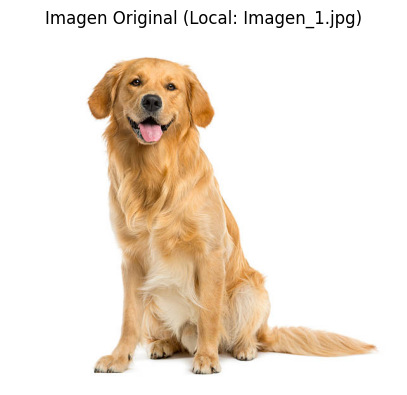

In [25]:
# --- Carga de Imagen de Ejemplo ---
img_cv_bgr = None
img_pil_rgb = None
display_title_suffix = ""

if USE_CIFAR10:
    print("Intentando cargar imagen de CIFAR-10")
    try:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        if 0 <= CIFAR_IMAGE_INDEX < len(x_train):
            cifar_img_numpy_rgb = x_train[CIFAR_IMAGE_INDEX] # Formato: NumPy, RGB, uint8
            print(f"Imagen de CIFAR-10 (índice: {CIFAR_IMAGE_INDEX}) cargada exitosamente.")
            display_title_suffix = f" (CIFAR-10, Índice {CIFAR_IMAGE_INDEX})"

            # Para OpenCV, convertir RGB a BGR
            img_cv_bgr = cv2.cvtColor(cifar_img_numpy_rgb, cv2.COLOR_RGB2BGR)
            # Para Pillow, crear desde el array NumPy RGB
            img_pil_rgb = Image.fromarray(cifar_img_numpy_rgb, 'RGB')

            print(f"Dimensiones de la imagen CIFAR-10: {img_cv_bgr.shape}")
        else:
            print(f"Error: Índice de CIFAR-10 {CIFAR_IMAGE_INDEX} fuera de rango (0-{len(x_train)-1}).")
            print("No se cargó ninguna imagen de CIFAR-10.")
    except Exception as e:
        print(f"Error al cargar o procesar CIFAR-10: {e}")
        print("Revise si TensorFlow está instalado y si hay conexión a internet para la descarga inicial del dataset.")

if img_cv_bgr is None and not USE_CIFAR10: # Si no se usó CIFAR o falló, intentar cargar imagen local
    print(f"Intentando cargar imagen local: '{IMAGE_PATH}'")
    try:
        img_cv_bgr = cv2.imread(IMAGE_PATH) # OpenCV carga en BGR
        if img_cv_bgr is None:
            raise FileNotFoundError(f"El archivo '{IMAGE_PATH}' no se pudo cargar con OpenCV.")
        img_pil_rgb = Image.open(IMAGE_PATH).convert('RGB') # Pillow carga y convierte a RGB

        print(f"Imagen local '{IMAGE_PATH}' cargada exitosamente.")
        display_title_suffix = f" (Local: {os.path.basename(IMAGE_PATH)})"
        print(f"Dimensiones de la imagen: {img_cv_bgr.shape}")
    except FileNotFoundError as e:
        print(e)
        print("Creando una imagen de ejemplo sintética porque la carga local falló")
        display_title_suffix = "(Sintética)"
        img_cv_bgr = np.zeros((100, 150, 3), dtype=np.uint8) # Más pequeña para sintética
        cv2.rectangle(img_cv_bgr, (10, 10), (60, 60), (0, 255, 0), -1)
        cv2.circle(img_cv_bgr, (100, 50), 25, (0, 0, 255), -1)
        img_pil_rgb = Image.fromarray(cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB), 'RGB')
        print("Imagen sintética creada.")
    except Exception as e:
        print(f"Ocurrió un error al cargar la imagen local: {e}")

# Mostrar la imagen original cargada
if img_pil_rgb:
    plt.figure(figsize=(5,5)) # Ajustar tamaño para CIFAR si es necesario
    plt.title(f"Imagen Original{display_title_suffix}")
    plt.imshow(img_pil_rgb) # img_pil_rgb ya está en formato RGB
    plt.axis('off')
    plt.show()
elif img_cv_bgr is not None: # Fallback si img_pil_rgb no se creó pero img_cv_bgr sí
    plt.figure(figsize=(5,5))
    plt.title(f"Imagen Original (OpenCV BGR){display_title_suffix}")
    plt.imshow(cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("--------------------------------------------------------------------")
    print("ADVERTENCIA: No se pudo cargar ninguna imagen (ni CIFAR-10 ni local/sintética).")
    print("El resto del script podría no producir resultados visuales.")
    print("Verifique la configuración de USE_CIFAR10, CIFAR_IMAGE_INDEX y IMAGE_PATH.")
    print("--------------------------------------------------------------------")

## **5. Técnicas de Preprocesamiento**

### **5.1 Conversión de Espacios de Color**
Convertir imágenes entre diferentes espacios de color es fundamental.

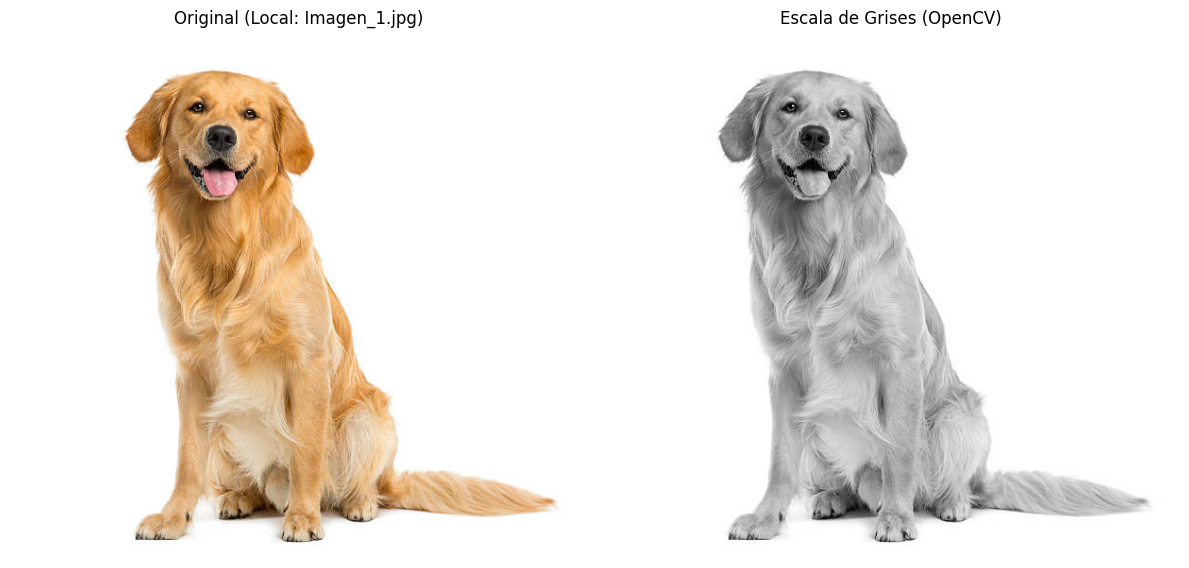

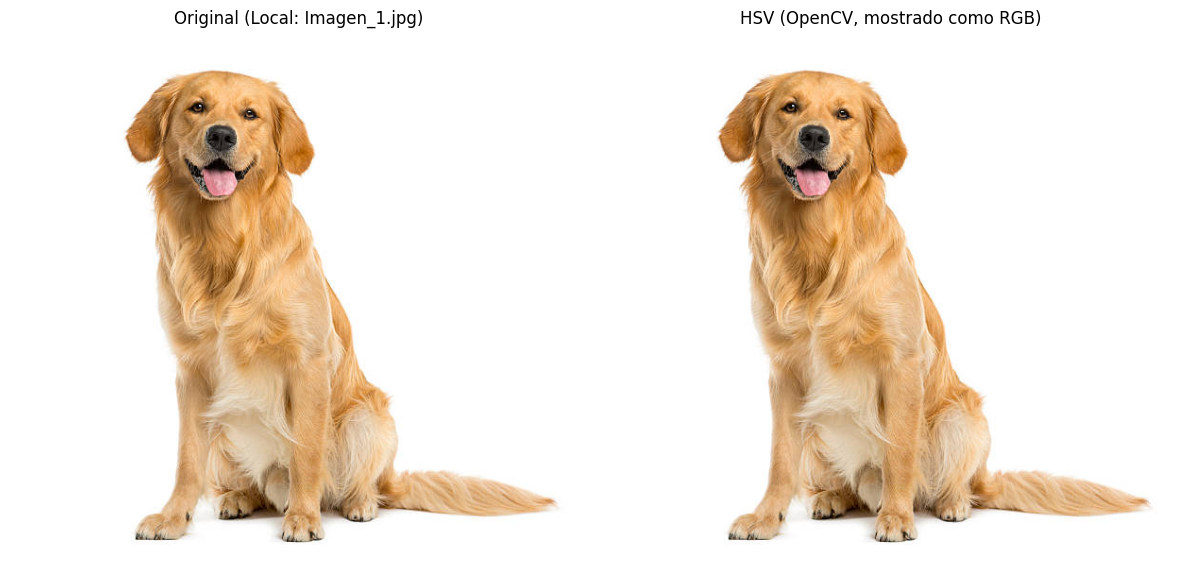

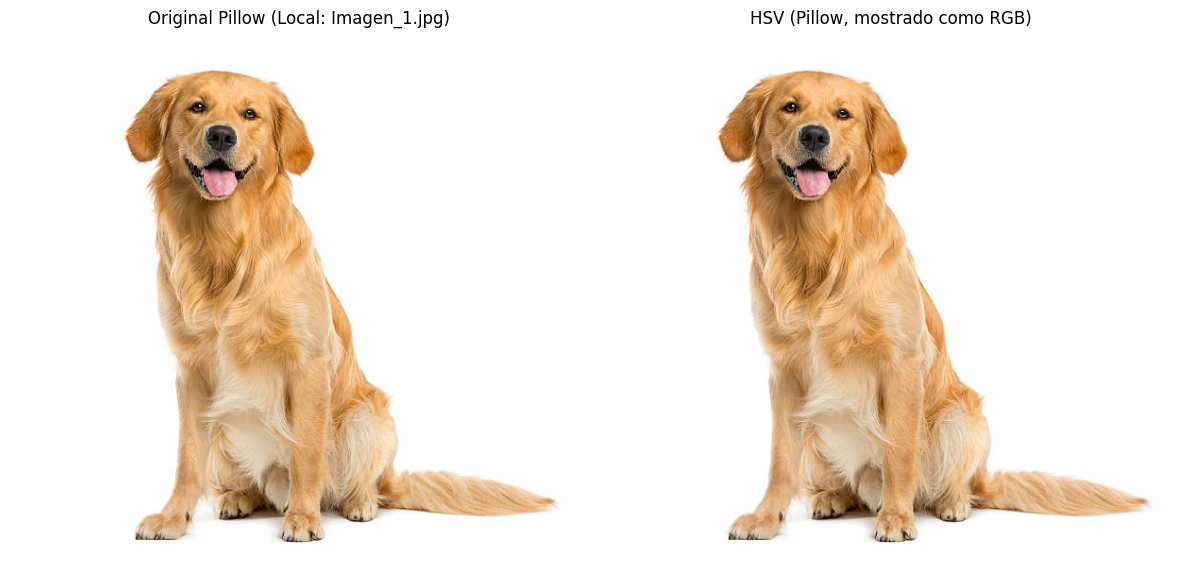

In [26]:
if img_cv_bgr is not None:
    title_orig = f"Original{display_title_suffix}"

    # Conversión a Escala de Grises (OpenCV)
    gray_cv = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2GRAY)
    display_images(cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB), gray_cv,
                   title_original=title_orig, title_processed="Escala de Grises (OpenCV)")

    # Conversión a HSV (OpenCV)
    hsv_cv = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2HSV)
    # Para visualizar HSV, a menudo se convierte de nuevo a BGR/RGB o se muestra un canal.
    # Aquí convertiremos HSV a RGB para una visualización directa.
    hsv_cv_rgb_display = cv2.cvtColor(hsv_cv, cv2.COLOR_HSV2RGB)
    display_images(cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB), hsv_cv_rgb_display,
                   title_original=title_orig, title_processed="HSV (OpenCV, mostrado como RGB)")

    if img_pil_rgb:
        # Conversión a HSV con Pillow
        hsv_pil = img_pil_rgb.convert('HSV')
        # Convertir HSV de Pillow a array NumPy (RGB) para visualización
        hsv_pil_rgb_array = np.array(hsv_pil.convert('RGB'))
        display_images(np.array(img_pil_rgb), hsv_pil_rgb_array,
                       title_original=f"Original Pillow{display_title_suffix}",
                       title_processed="HSV (Pillow, mostrado como RGB)")
else:
    print("img_cv_bgr no está disponible. Saltando conversiones de espacio de color.")

### **5.2 Redimensionamiento y Recorte**
Esencial para estandarizar entradas a modelos y enfocar el análisis.

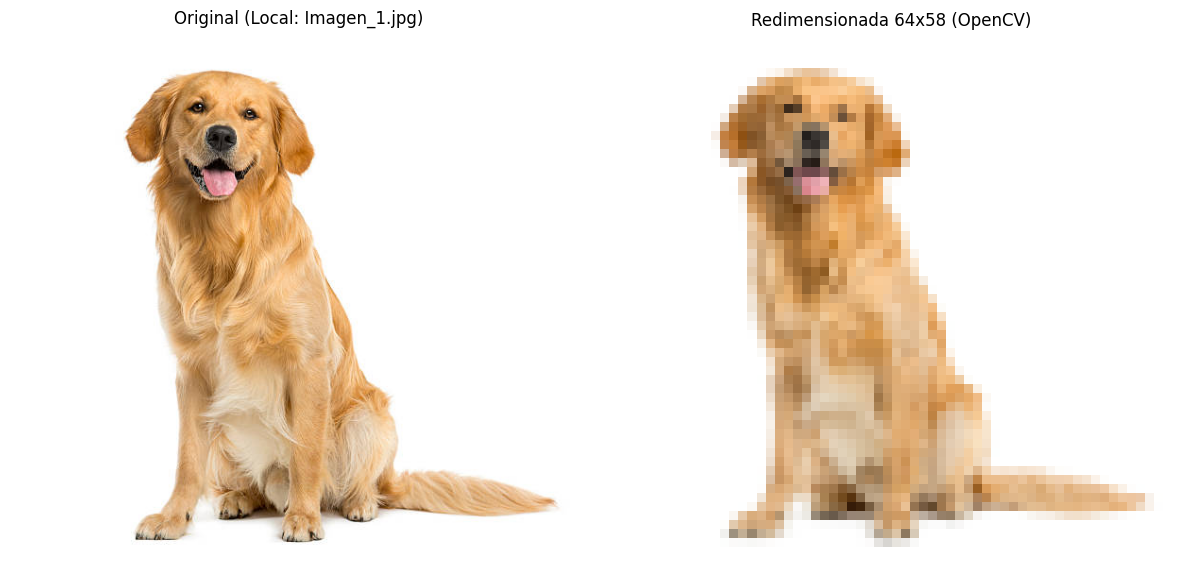

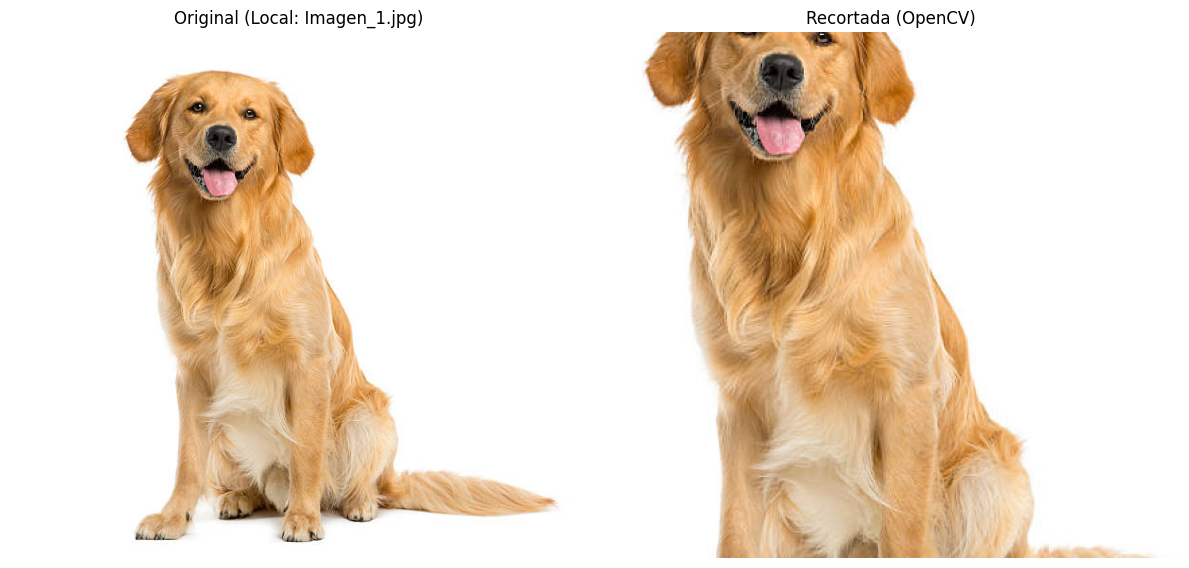

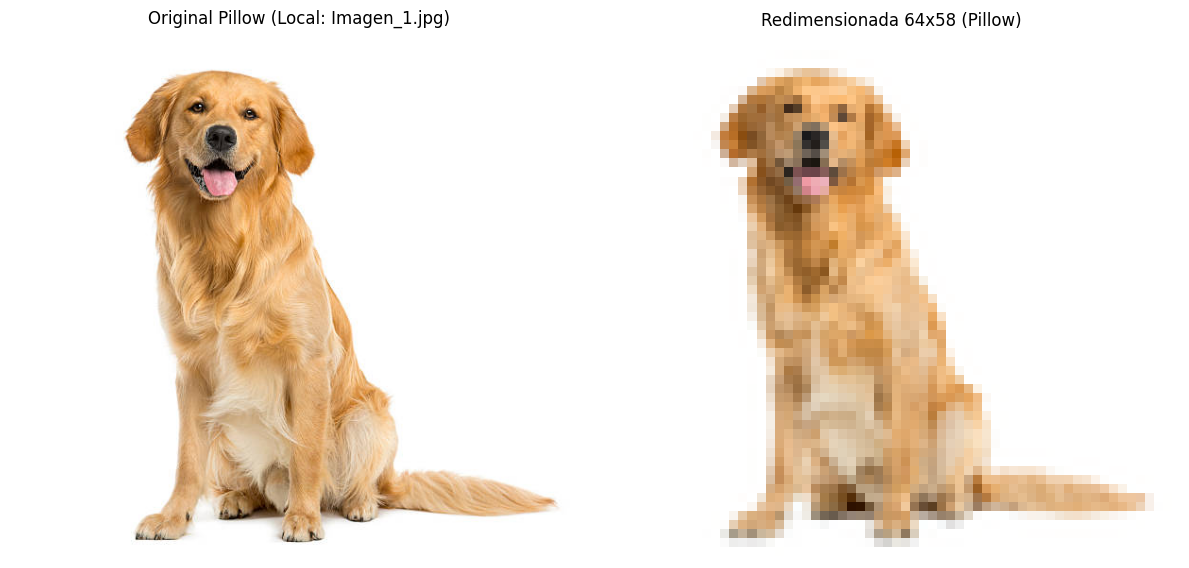

In [27]:
if img_cv_bgr is not None:
    title_orig = f"Original{display_title_suffix}"
    img_original_rgb = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB)

    # Redimensionamiento con OpenCV
    new_width = 64 # CIFAR es 32x32, así que agrandemos un poco; si es local, se ajustará
    aspect_ratio = new_width / img_cv_bgr.shape[1]
    new_height = int(img_cv_bgr.shape[0] * aspect_ratio)
    if new_height == 0: new_height = new_width # Evitar altura cero para imágenes muy delgadas
    
    resized_cv_bgr = cv2.resize(img_cv_bgr, (new_width, new_height), interpolation=cv2.INTER_AREA if new_width < img_cv_bgr.shape[1] else cv2.INTER_LINEAR)
    display_images(img_original_rgb, cv2.cvtColor(resized_cv_bgr, cv2.COLOR_BGR2RGB),
                   title_original=title_orig, title_processed=f"Redimensionada {new_width}x{new_height} (OpenCV)")

    # Recorte (Cropping) con OpenCV
    h, w = img_cv_bgr.shape[:2]
    if h > 10 and w > 10: # Solo si la imagen es suficientemente grande para recortar
        start_row, start_col = int(h * 0.15), int(w * 0.15) # Recortar un poco menos para CIFAR
        end_row, end_col = int(h * 0.85), int(w * 0.85)
        cropped_cv_bgr = img_cv_bgr[start_row:end_row, start_col:end_col]
        display_images(img_original_rgb, cv2.cvtColor(cropped_cv_bgr, cv2.COLOR_BGR2RGB),
                       title_original=title_orig, title_processed="Recortada (OpenCV)")
    else:
        print("Imagen demasiado pequeña para el recorte de ejemplo.")

    if img_pil_rgb:
        # Redimensionamiento con Pillow
        resized_pil_rgb = img_pil_rgb.resize((new_width, new_height), Image.Resampling.LANCZOS)
        display_images(np.array(img_pil_rgb), np.array(resized_pil_rgb),
                       title_original=f"Original Pillow{display_title_suffix}",
                       title_processed=f"Redimensionada {new_width}x{new_height} (Pillow)")
else:
    print("img_cv_bgr no está disponible. Saltando redimensionamiento y recorte.")

### **5.3 Normalización de Píxeles y Ecualización de Histograma**
Ajustan valores de píxeles y mejoran el contraste.

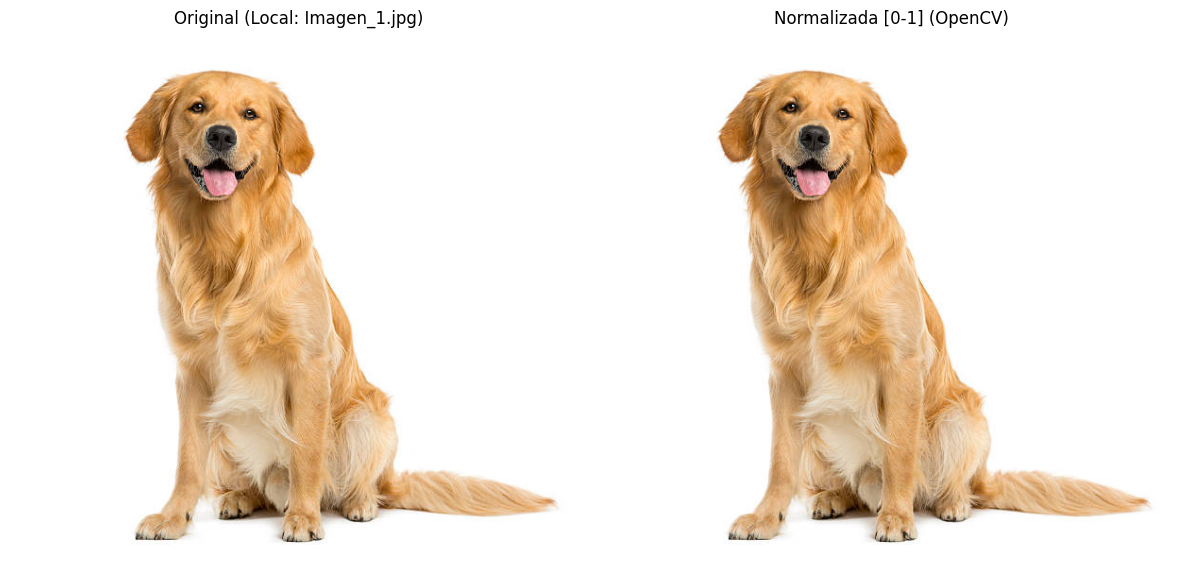

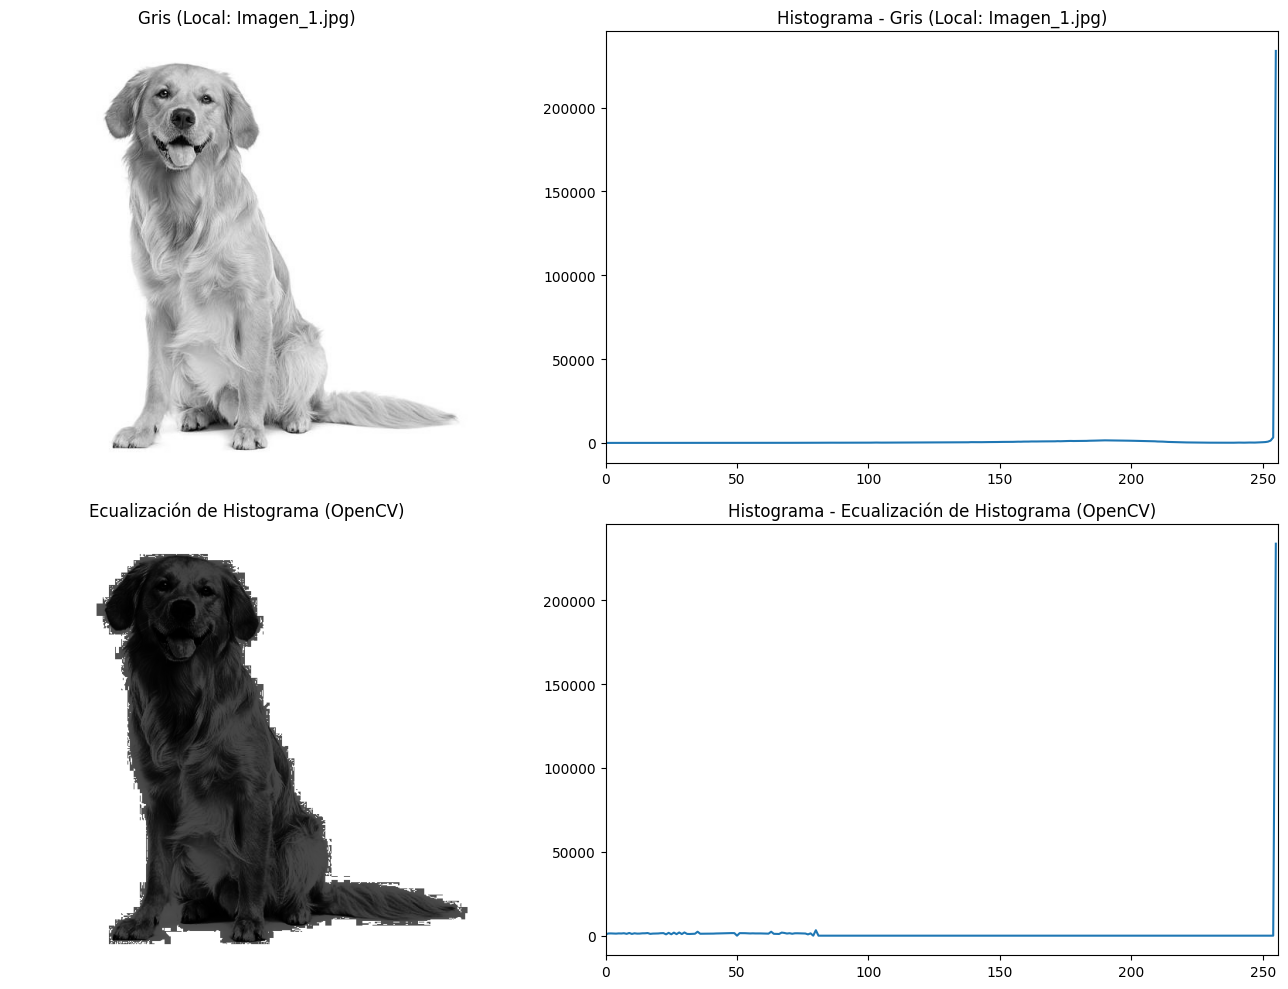

In [28]:
if img_cv_bgr is not None:
    title_orig = f"Original{display_title_suffix}"
    img_original_rgb = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB)

    # Normalización de Píxeles (Escalado a 0-1)
    normalized_cv_rgb = img_cv_bgr.astype(np.float32) / 255.0
    # Convertir BGR normalizado a RGB normalizado para visualización
    if len(normalized_cv_rgb.shape) == 3: # Si es color
         normalized_cv_rgb = cv2.cvtColor(normalized_cv_rgb, cv2.COLOR_BGR2RGB)

    display_images(img_original_rgb, normalized_cv_rgb,
                   title_original=title_orig, title_processed="Normalizada [0-1] (OpenCV)")

    # Ecualización de Histograma (OpenCV)
    gray_img_for_hist = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2GRAY)
    equalized_cv_gray = cv2.equalizeHist(gray_img_for_hist)
    display_images_with_histograms(gray_img_for_hist, equalized_cv_gray,
                                   title_original=f"Gris{display_title_suffix}",
                                   title_processed="Ecualización de Histograma (OpenCV)")
else:
    print("img_cv_bgr no está disponible. Saltando normalización y ecualización.")

### **5.4 Aplicación de Filtros**
Para reducir ruido, suavizar o realzar bordes.

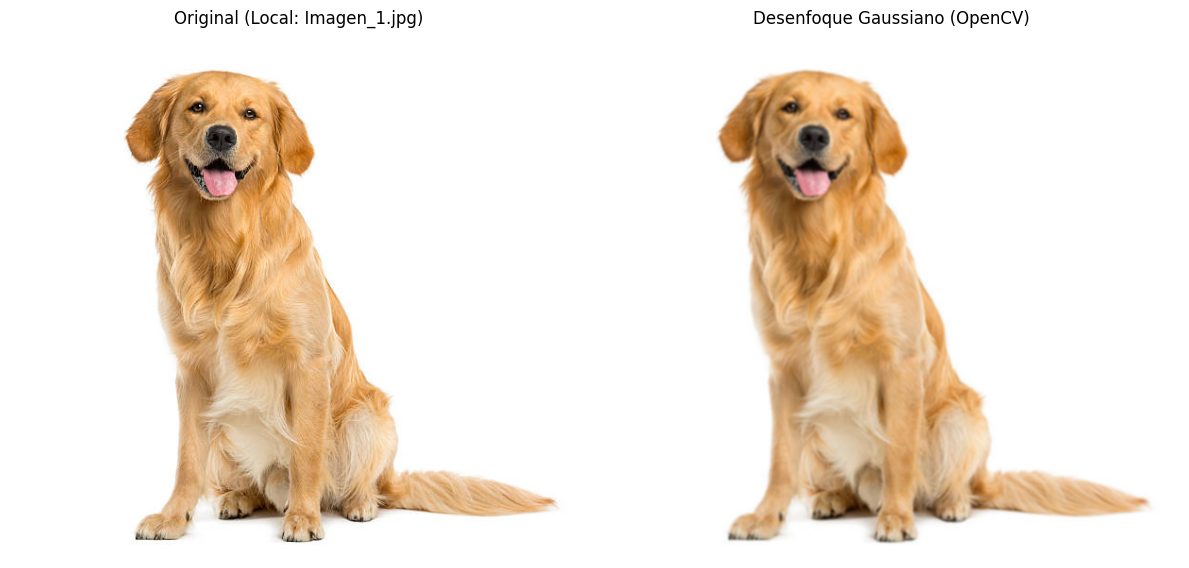

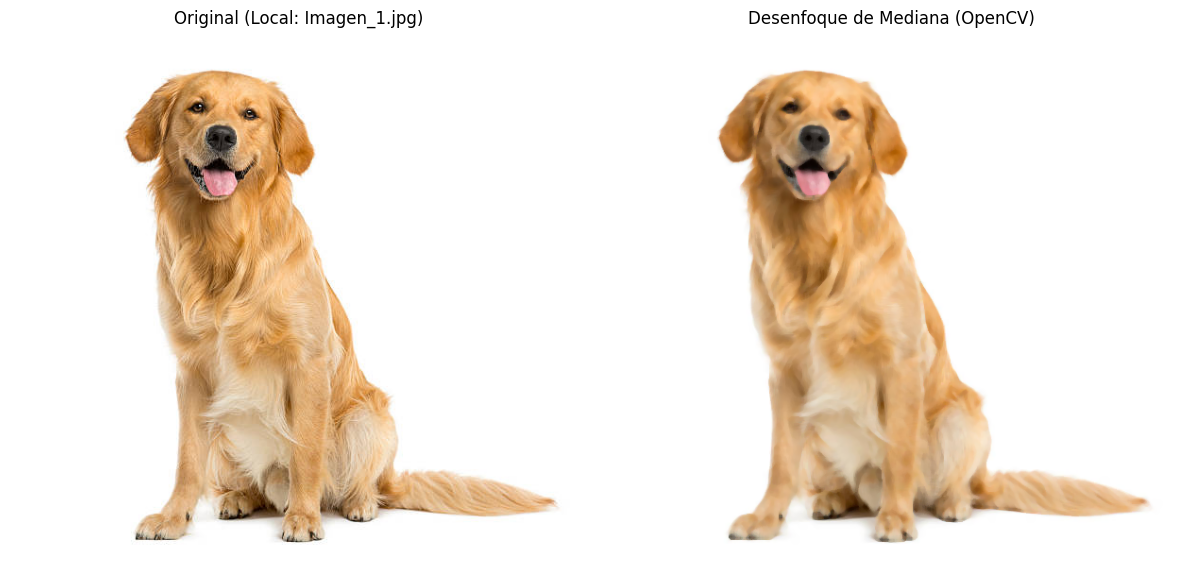

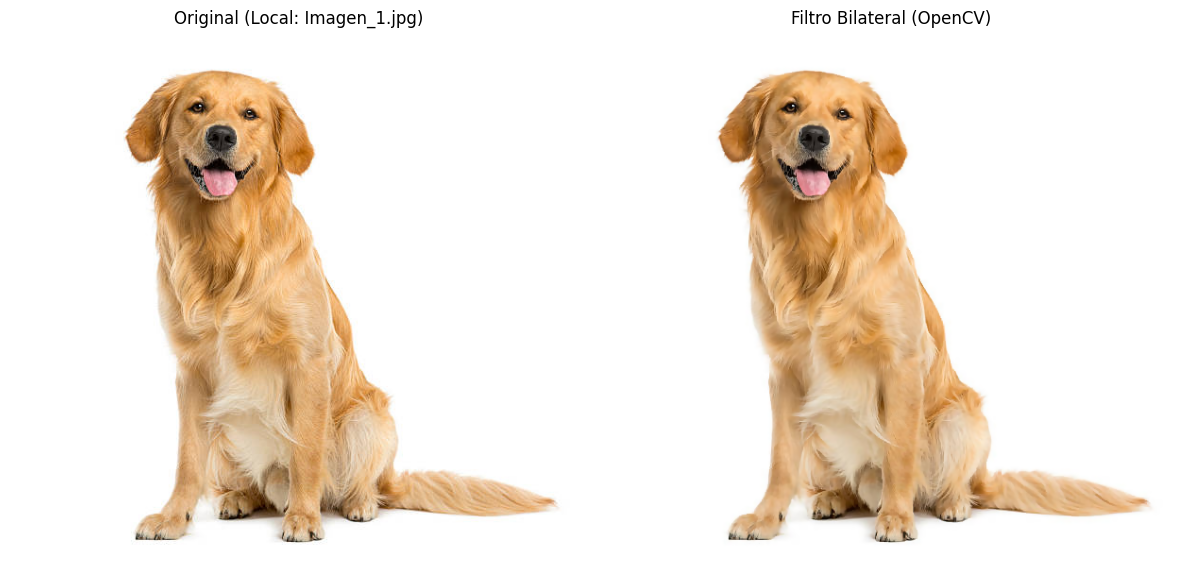

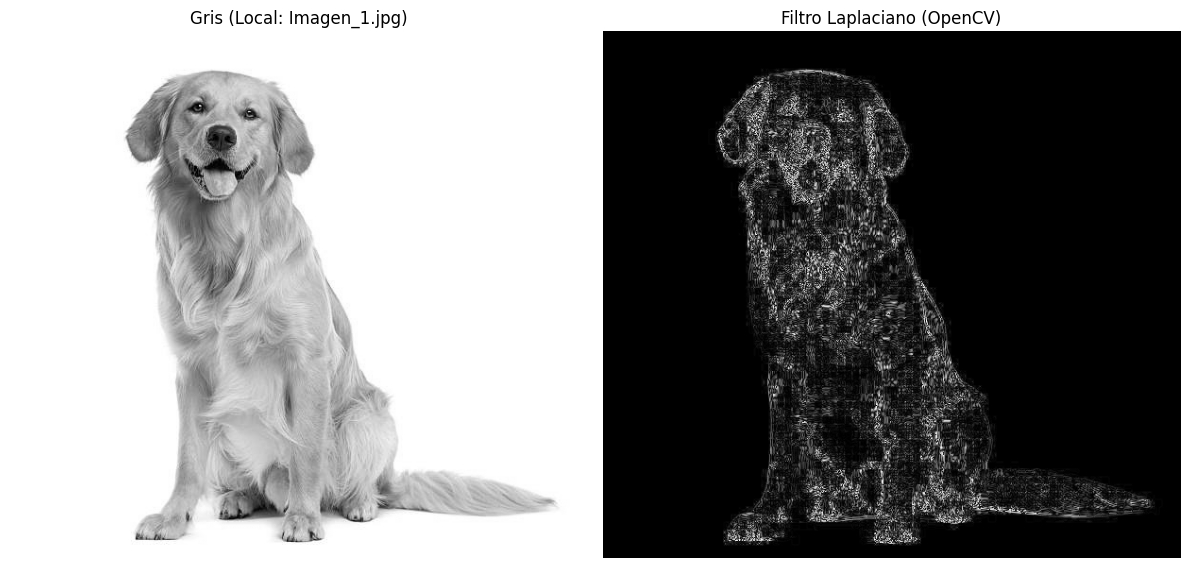

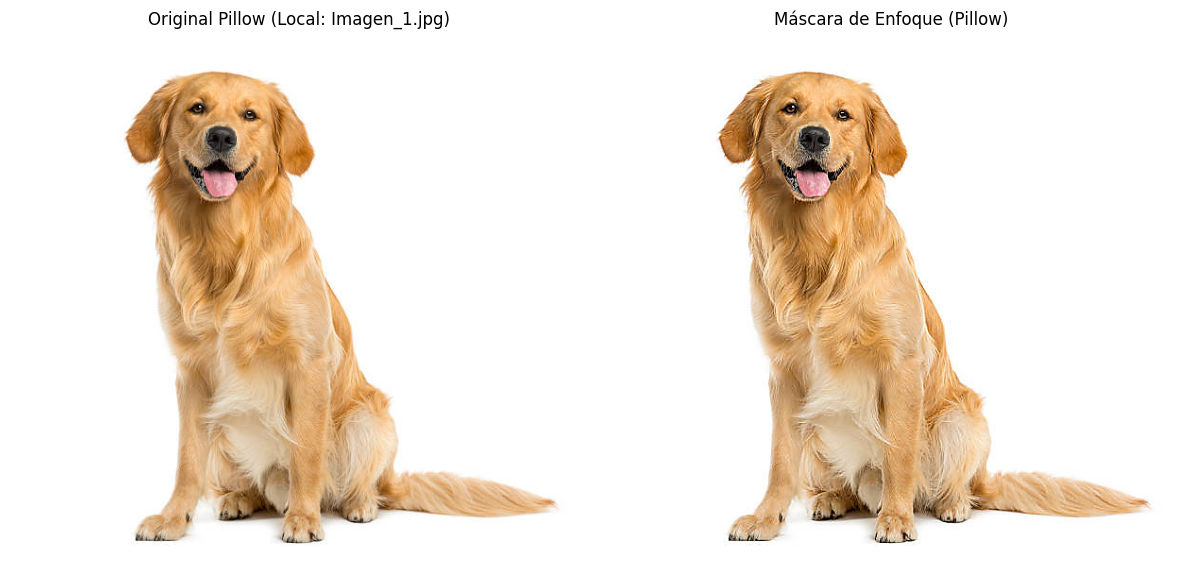

In [33]:
if img_cv_bgr is not None:
    title_orig = f"Original{display_title_suffix}"
    img_original_rgb = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB)

    # Desenfoque Gaussiano (Gaussian Blur)
    # El tamaño del kernel debe ser impar (ej. 3x3 o 5x5 para CIFAR).
    kernel_size = (3,3) if img_cv_bgr.shape[0] <= 32 else (5,5)
    gaussian_blur_bgr = cv2.GaussianBlur(img_cv_bgr, kernel_size, 0)
    display_images(img_original_rgb, cv2.cvtColor(gaussian_blur_bgr, cv2.COLOR_BGR2RGB),
                   title_original=title_orig, title_processed="Desenfoque Gaussiano (OpenCV)")

    # Desenfoque de Mediana (Median Blur)
    median_kernel = 3 if img_cv_bgr.shape[0] <= 32 else 5
    median_blur_bgr = cv2.medianBlur(img_cv_bgr, median_kernel)
    display_images(img_original_rgb, cv2.cvtColor(median_blur_bgr, cv2.COLOR_BGR2RGB),
                   title_original=title_orig, title_processed="Desenfoque de Mediana (OpenCV)")

    # Filtro Bilateral
    bilateral_bgr = cv2.bilateralFilter(img_cv_bgr, d=5, sigmaColor=35, sigmaSpace=35) # d pequeño para CIFAR
    display_images(img_original_rgb, cv2.cvtColor(bilateral_bgr, cv2.COLOR_BGR2RGB),
                   title_original=title_orig, title_processed="Filtro Bilateral (OpenCV)")

    # Filtro Laplaciano (Detección de Bordes)
    gray_for_laplacian = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2GRAY)
    laplacian_cv = cv2.Laplacian(gray_for_laplacian, cv2.CV_64F, ksize=3)
    laplacian_cv_abs_gray = np.uint8(np.absolute(laplacian_cv))
    display_images(gray_for_laplacian, laplacian_cv_abs_gray,
                   title_original=f"Gris{display_title_suffix}", title_processed="Filtro Laplaciano (OpenCV)")

    if img_pil_rgb:
        # Máscara de Enfoque (Unsharp Masking) con Pillow
        unsharp_pil_rgb = img_pil_rgb.filter(PILImageFilter.UnsharpMask(radius=1, percent=100, threshold=5)) # params ajustados
        display_images(np.array(img_pil_rgb), np.array(unsharp_pil_rgb),
                       title_original=f"Original Pillow{display_title_suffix}",
                       title_processed="Máscara de Enfoque (Pillow)")
else:
    print("img_cv_bgr no está disponible. Saltando aplicación de filtros.")

### **5.5 Aumentación de Datos Básica**
Crea variaciones de las imágenes para enriquecer datasets de entrenamiento.

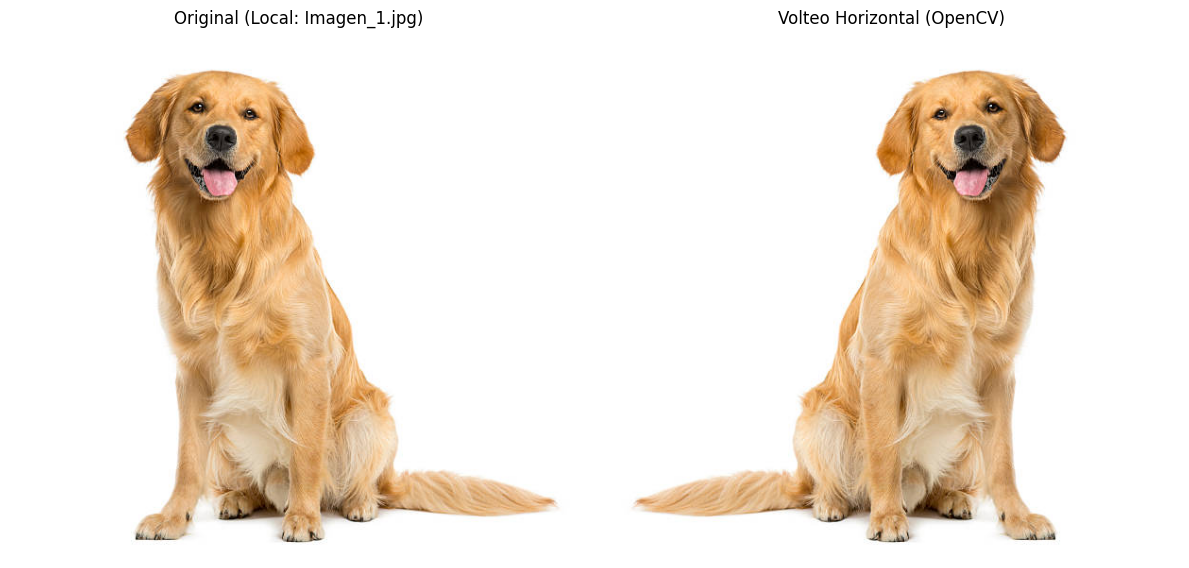

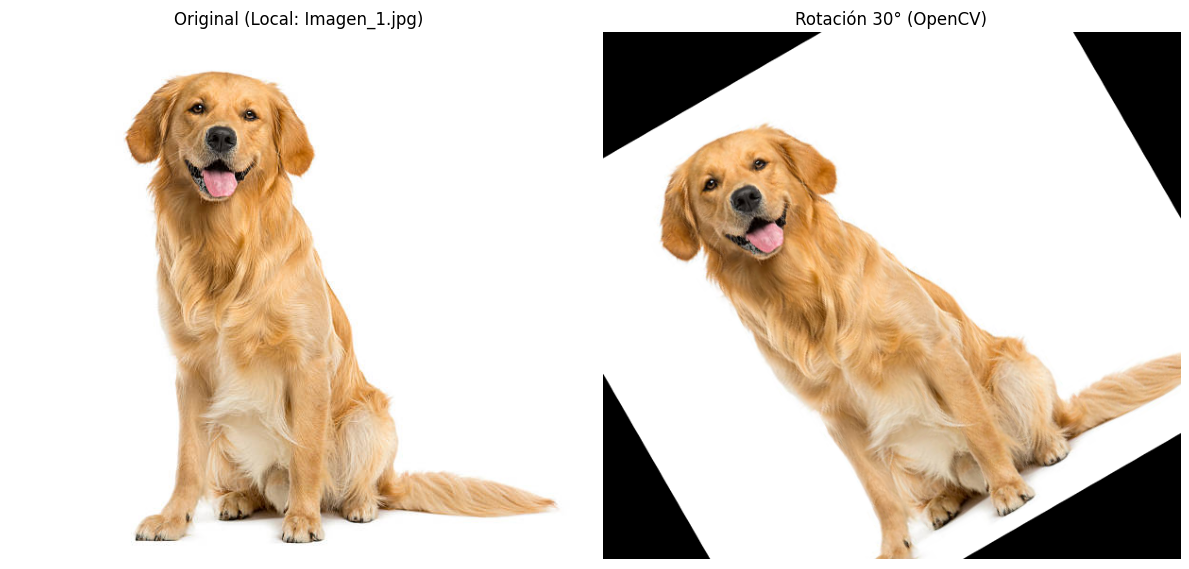

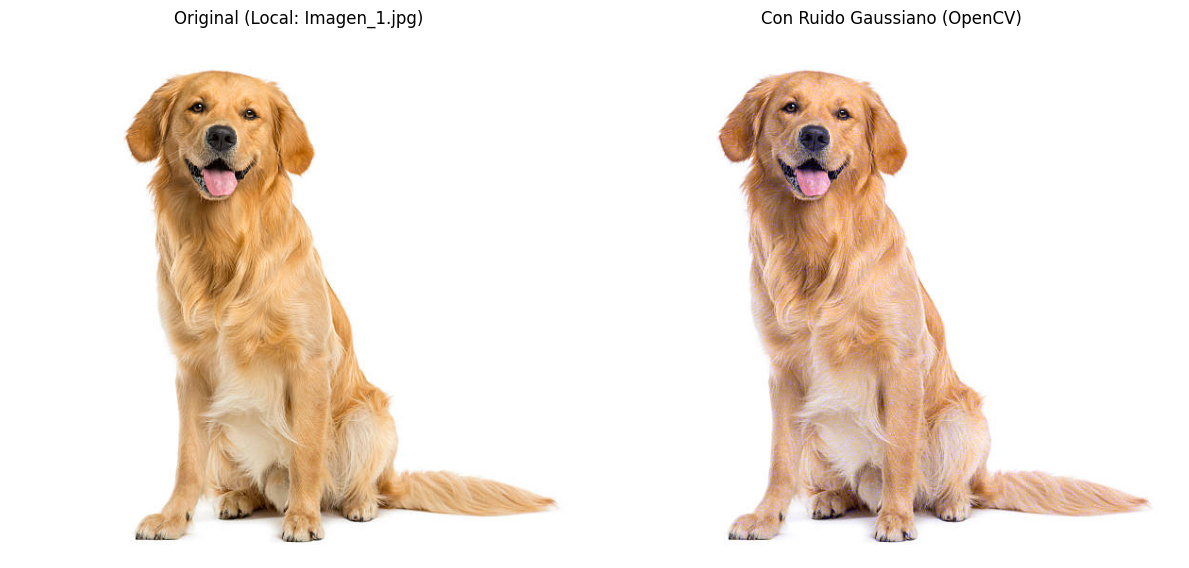

In [32]:
if img_cv_bgr is not None:
    title_orig = f"Original{display_title_suffix}"
    img_original_rgb = cv2.cvtColor(img_cv_bgr, cv2.COLOR_BGR2RGB)

    # Volteo Horizontal (Flipping)
    flipped_bgr = cv2.flip(img_cv_bgr, 1) # 1 para horizontal
    display_images(img_original_rgb, cv2.cvtColor(flipped_bgr, cv2.COLOR_BGR2RGB),
                   title_original=title_orig, title_processed="Volteo Horizontal (OpenCV)")

    # Rotación
    (h, w) = img_cv_bgr.shape[:2]
    center = (w // 2, h // 2)
    angle = 30 # Menor ángulo para imágenes pequeñas
    scale = 1.0
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated_bgr = cv2.warpAffine(img_cv_bgr, M, (w, h))
    display_images(img_original_rgb, cv2.cvtColor(rotated_bgr, cv2.COLOR_BGR2RGB),
                   title_original=title_orig, title_processed=f"Rotación {angle}° (OpenCV)")

    # Adición de Ruido Gaussiano
    mean = 0
    stddev = 50 # Menor stddev para CIFAR
    noise = np.zeros(img_cv_bgr.shape, np.uint8)
    cv2.randn(noise, mean, stddev)
    noisy_img_bgr = cv2.add(img_cv_bgr, noise)
    display_images(img_original_rgb, cv2.cvtColor(noisy_img_bgr, cv2.COLOR_BGR2RGB),
                   title_original=title_orig, title_processed="Con Ruido Gaussiano (OpenCV)")
else:
    print("img_cv_bgr no está disponible. Saltando aumentación de datos.")

## **6. Conclusiones**

Este script ha demostrado la aplicación de varias técnicas fundamentales de preprocesamiento de imágenes, utilizando tanto imágenes locales como ejemplos del dataset CIFAR-10. Estas técnicas son cruciales para preparar datos para modelos de visión por computadora y aprendizaje automático.

In [31]:
print("Fin del script de demostración de preprocesamiento de imágenes.")

Fin del script de demostración de preprocesamiento de imágenes.
